# Library Loading

In [13]:
# Advertising Simulator
# This program simulates the advertising of a product over a period of time.
# It will simulate the number of people who have seen the product advertising, brand experience, and product experience.

import numpy as np
import pandas as pd 
import math
import seaborn as sns
import matplotlib.pyplot as plt


# User Defined Class and Function

## Class: Customer

In [14]:
class customer:
    def __init__(self):
        # Awareness
        self.advertising_exposure = {}
        # Interest
        # Attitude towards advertising
        self.attitude_towards_advertising = {}
        # Desire
        self.attitude_towards_brand = {}
        # Action: Purchase decision
        self.brand_experience = {}
        # Budget
        self.budget = np.random.randint(1000, 5000)
        # Purchase decision
        self.likelihood_of_purchase = {}
        
    def couch_time(self, brand_name, campaign_name, effectiveness, brand_power):
        # Advertising Exposure
        if campaign_name not in self.advertising_exposure:
            self.advertising_exposure[campaign_name] = 1
        else:
            self.advertising_exposure[campaign_name] += 1
        
        # Attitude towards advertising
        if campaign_name not in self.attitude_towards_advertising:
            self.attitude_towards_advertising[campaign_name] = 1
        else:
            if self.attitude_towards_advertising[campaign_name] <= 100:
                self.attitude_towards_advertising[campaign_name] += np.log(effectiveness * self.advertising_exposure[campaign_name]+ 1)
        
        # Attitude towards brand
        if brand_name not in self.attitude_towards_brand:
            self.attitude_towards_brand[brand_name] = 1
        else:
            if self.attitude_towards_brand[brand_name] <= 100:
                self.attitude_towards_brand[brand_name] += np.log(1 + brand_power * self.attitude_towards_advertising[campaign_name] + self.brand_experience[brand_name])
                for other_brand in self.attitude_towards_brand.keys():
                    if other_brand != brand_name:
                        self.attitude_towards_brand[other_brand] -= np.random.normal(0, 0.5) * np.log(1 + brand_power * self.attitude_towards_advertising[campaign_name] + self.brand_experience[brand_name])
                        self.attitude_towards_brand[other_brand] = max(0, self.attitude_towards_brand[other_brand])


    def purchase(self, brand_name, item_price, brand_sales):
        # Random seed assignment
        np.random.seed(0)
        # Purchase decision
        # Purchase decision is binary variable, 1 for purchase and 0 for no purchase
        # If there is a previous brand experience, the probability of purchase will be higher than brand without experience
        if brand_name not in self.brand_experience:
            self.brand_experience[brand_name] = 0

        # Get the likelihood of purchase which will be used for binomial distribution.
        # Sigmoid function to get the probability of purchase to bound in range between 0 and 1
        if self.brand_experience[brand_name] == 0:
            # Without this condition, if the customers are exposed to same brand advertising several times at the beginning, the likelihood of purchase will be 1 and this will lead to np.log to zero.
            # In other words, the likelihood of purchase will be 0.5 for first few times.
            # This is not correct considering the nature of the advertising exposures in our daily life.
            # We are exposed to two brands' advertisings repeadetly.
            if self.attitude_towards_brand[brand_name] == sum(self.attitude_towards_brand.values()):
                # Due to the reason, put the likelihood of purchase to random variable generation.
                # Considering the nature of randomness in consumer behavior, this is more realistic.
                likelihood_of_purchase = np.random.uniform(0, 0.5)
            else:
                likelihood_of_purchase = np.log((self.attitude_towards_brand[brand_name]) / sum(self.attitude_towards_brand.values()))
        else:
            likelihood_of_purchase = np.log((self.attitude_towards_brand[brand_name]) / sum(self.attitude_towards_brand.values())) * np.log(self.brand_experience[brand_name])

        #likelihood_of_purchase = np.log((self.attitude_towards_brand[brand_name])  / sum(self.attitude_towards_brand.values())) 
        likelihood_of_purchase = sigmoid(likelihood_of_purchase)
        
        
        # if brand_name not in self.likelihood_of_purchase:
        if brand_name not in self.likelihood_of_purchase:
            self.likelihood_of_purchase[brand_name] = []
        # append the likelihood of purchase to the list
        self.likelihood_of_purchase[brand_name].append(likelihood_of_purchase)
        

        # Purchase decision
        status = np.random.binomial(1, likelihood_of_purchase)
        if status == 1 and self.budget > item_price:
            self.brand_experience[brand_name] += 1
            brand_sales += item_price
            return brand_sales
        else:
            # print("Not enough money to purchase the item.")
            self.budget += np.random.randint(100, 500)
            return brand_sales
                   
    def __str__(self):
        return "Attitude towards brand: " + str(self.attitude_towards_brand) + ", Attitude towards advertising: " + str(self.attitude_towards_advertising) + ", Advertising Exposure: " + str(self.advertising_exposure)
              

## Class: Brand

In [15]:
class brand:
    def __init__(self, brand_name, brand_budget, brand_power, item_price):
        self.brand_name = brand_name
        self.advertising_spending = 0
        self.advertising_budget = brand_budget
        self.brand_power = brand_power
        self.campaign = {}
        self.item_price = item_price
        self.brand_sales = 0
        campaign_name_lst = [self.brand_name + " Campaign " + str(i) for i in range(np.random.randint(3, 10))]
        for ad_campaign in campaign_name_lst:
            self.campaign[ad_campaign] = {}
            self.campaign[ad_campaign]["expense"] = np.random.normal(3,1)
            self.campaign[ad_campaign]["exposure"] = 0
            self.campaign[ad_campaign]["advertising_effectiveness"] = np.random.normal(1,0.25)
            # self.campaign[ad_campaign]["total_expense"] += self.campaign[ad_campaign]["expense"]


    def advertise(self, customer):
        ad_campaign = np.random.choice([element for element in self.campaign.keys()])
        if self.advertising_budget > self.campaign[ad_campaign]["expense"]:
            self.advertising_budget -= self.campaign[ad_campaign]["expense"]
            self.advertising_spending += self.campaign[ad_campaign]["expense"]
            self.campaign[ad_campaign]["exposure"] += 1
            customer.couch_time(self.brand_name, ad_campaign, self.campaign[ad_campaign]["advertising_effectiveness"], self.brand_power)
            self.brand_sales = customer.purchase(self.brand_name, self.item_price, self.brand_sales)
        else:
            print("No budget left for advertising")
            self.brand_sales = customer.purchase(self.brand_name, self.item_price, self.brand_sales/100)

## Function: Sigmoid

In [16]:

def sigmoid(x):
    return (1 / (1 + math.exp(-x)))

## Function: Simulate - likelihood

In [17]:
def simulate(customers, brands, number_of_simulations):
    ads_effects = []
    # Expose advertisings
    for n in range(number_of_simulations):
        np.random.seed(n)
        i = np.random.choice(range(len(customers)))
        j = np.random.choice(range(len(brands)))
        brands[j].advertise(customers[i])
        ads_effects.append([i, 
                            j, 
                            customers[i].likelihood_of_purchase])

    # Create a dataframe
    df = pd.DataFrame(ads_effects, columns = ["Customer", 
                                            "Brand", 
                                            "Likelihood of Purchase"] )

    tmp = df[['Customer', 'Brand', 'Likelihood of Purchase']]
    temp = pd.concat([tmp[["Customer", "Brand"]], tmp["Likelihood of Purchase"].apply(pd.Series)], axis = 1)
    temp = temp.drop_duplicates(["Customer", "Brand"], keep = "last").melt(id_vars = ["Customer", "Brand"], value_name = "Likelihood of Purchase")
    temp = temp.explode("Likelihood of Purchase", ignore_index = False).reset_index().rename(columns = {"index": "id"})
    # temp = temp.explode("Likelihood of Purchase", ignore_index = True)
    temp["customer_brand"] = temp["Customer"].astype(str) + "-" + temp["Brand"].astype(str)
    return temp


## Function: Visualize - Simulation 

In [18]:
# transform the simulation outcome to a dataframe for visualization.
def visualize(dataframe):
    '''
    unique_id = dataframe["id"].unique()
    brand_lst = dataframe["variable"].unique()
    dataframe = dataframe[dataframe["Brand"] == 0]
    return_df = pd.DataFrame()
    for id in unique_id:
        for brandname in brand_lst:
            tmp1 = dataframe[(dataframe["id"] == id) & (dataframe["variable"] == brandname)].reset_index(drop = True).reset_index(drop = False)
            #tmp1 = dataframe[(dataframe["id"] == id)].reset_index(drop = True).reset_index(drop = False)
            return_df = pd.concat([return_df, tmp1])
    return return_df
    '''
    dataframe["index"] = dataframe.groupby(["id", "variable"]).cumcount()
    return dataframe

## Function: Customer_mind - Top # of brands in consumer mind

In [19]:
def customer_mind(dataframe):
    final = dataframe.drop_duplicates(["Customer", "Brand", "variable"], keep = "last").sort_values(by = ["Customer", "Brand", "Likelihood of Purchase"], ascending = [True, True, False]).reset_index(drop = True)
    return_df = pd.DataFrame()
    for i in final["id"].unique():
        tmp = final[final["id"] == i]
        max_value = tmp["Likelihood of Purchase"].max()
        if len(tmp) > 0:
            tmp["NumberOfFavorites"] = len(tmp[tmp["Likelihood of Purchase"] >= max_value - 0.01])
            return_df = pd.concat([return_df, tmp])
    return return_df


# Duopoly

## Scenario #1: When Brand has same amound of budget, same brand power, and same product price

In [20]:
# Customer objects
customers = [customer() for i in range(1000)]

# Brand objects
brands = [brand("Coca-Cola", 1000000, 100, 1.79), 
          brand("Pepsi", 1000000, 100, 1.79)
          ]

# Simulate the advertising
number_of_simulations = 100000
duo1 = simulate(customers, brands, number_of_simulations)


<Axes: xlabel='index', ylabel='Likelihood of Purchase'>

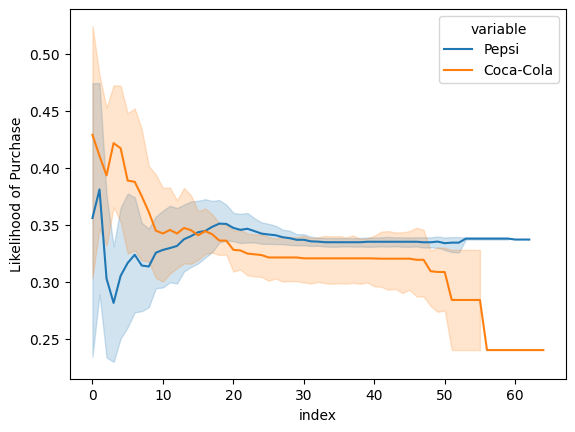

In [37]:
duo1_ = visualize(duo1)
customer_brand_lst = np.random.choice(duo1_["customer_brand"].unique(), 10)
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo1_[duo1_["customer_brand"].isin(customer_brand_lst)], hue = "variable")

In [24]:
last_pref = duo1.drop_duplicates(["Customer", "Brand", "variable"], keep = "last").sort_values(by = ["Customer", "Brand", "Likelihood of Purchase"], ascending = [True, True, False]).reset_index(drop = True).drop_duplicates(["Customer"], keep = "first")
last_pref["variable"].value_counts(normalize = True)

variable
Coca-Cola    0.502
Pepsi        0.498
Name: proportion, dtype: float64

## Scenario #2: When Brand has same amound of budget, different brand power, and same price

In [25]:
# Customer objects
customers = [customer() for i in range(1000)]

# Brand objects
brands = [brand("Coca-Cola", 1000000, 100, 1.79), 
        brand("Pepsi", 1000000, 10, 1.79)
        ]

duo2 = simulate(customers, brands, number_of_simulations)

In [26]:
duo2_ = visualize(duo2)

<Axes: xlabel='index', ylabel='Likelihood of Purchase'>

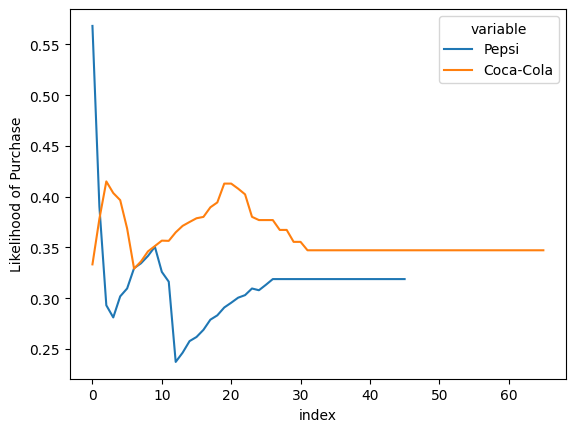

In [27]:
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo2_[duo2_["customer_brand"] == "9-0"], hue = "variable")

In [28]:
last_pref = duo2.drop_duplicates(["Customer", "Brand", "variable"], keep = "last").sort_values(by = ["Customer", "Brand", "Likelihood of Purchase"], ascending = [True, True, False]).reset_index(drop = True).drop_duplicates(["Customer"], keep = "first")
last_pref["variable"].value_counts(normalize = True)

variable
Coca-Cola    0.526
Pepsi        0.474
Name: proportion, dtype: float64

## Scenario #3: When Brand has same amound of budget, different brand power, and same price

In [29]:
# Customer objects
customers = [customer() for i in range(1000)]

# Brand objects
brands = [brand("Coca-Cola", 1000000, 100, 1.79), 
        brand("Pepsi", 1000000, 1000, 1.79)
        ]

duo3 = simulate(customers, brands, number_of_simulations)

In [30]:
duo3_ = visualize(duo3)

<Axes: xlabel='index', ylabel='Likelihood of Purchase'>

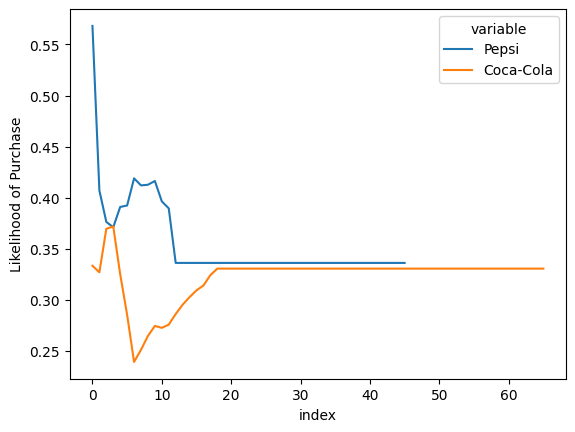

In [31]:
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo3_[duo3_["customer_brand"] == "9-0"], hue = "variable")

In [32]:
last_pref = duo3.drop_duplicates(["Customer", "Brand", "variable"], keep = "last").sort_values(by = ["Customer", "Brand", "Likelihood of Purchase"], ascending = [True, True, False]).reset_index(drop = True).drop_duplicates(["Customer"], keep = "first")
last_pref["variable"].value_counts(normalize = True)

variable
Pepsi        0.555
Coca-Cola    0.445
Name: proportion, dtype: float64

Text(0.5, 1.0, 'Brand Power: 1000')

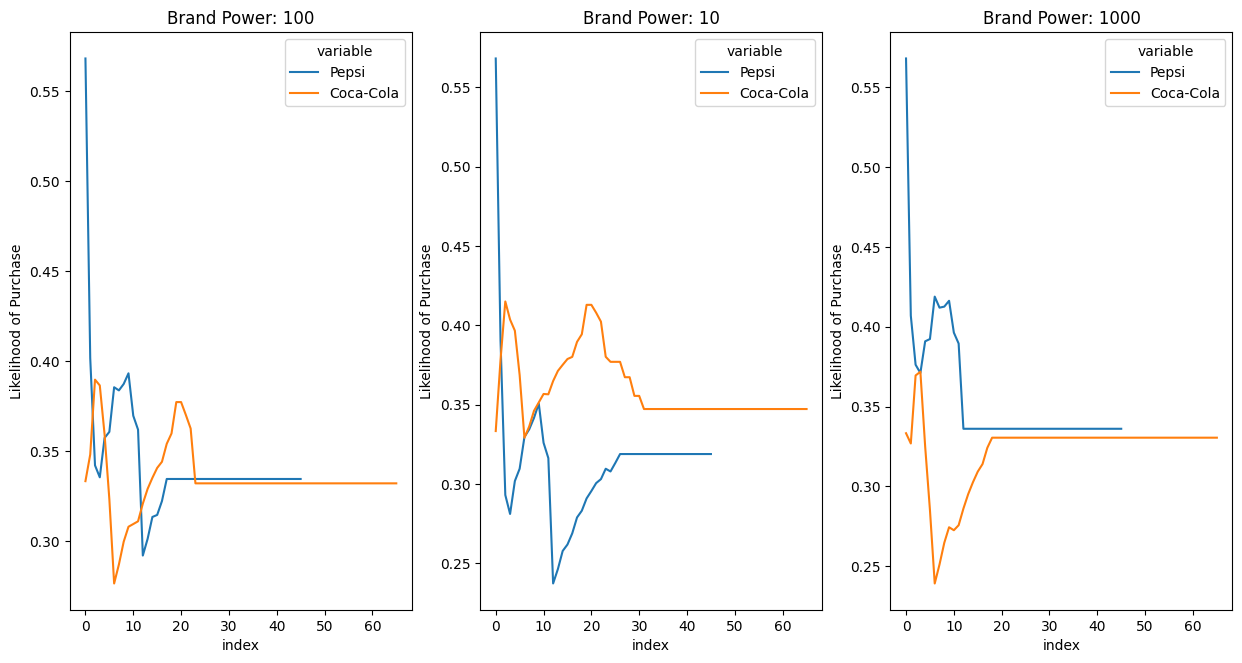

In [42]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(7.5)
fig.set_figwidth(15)
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo1_[duo1_["customer_brand"] == "9-0"], hue = "variable", ax = axs[0])
axs[0].set_title("Brand Power: 100")
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo2_[duo2_["customer_brand"] == "9-0"], hue = "variable", ax = axs[1])
axs[1].set_title("Brand Power: 10")
sns.lineplot(x="index", y="Likelihood of Purchase", data=duo3_[duo3_["customer_brand"] == "9-0"], hue = "variable", ax = axs[2])
axs[2].set_title("Brand Power: 1000")

In [43]:
tmp = customer_mind(duo1)

/var/folders/18/f6859mdn6s90ts9cjb_nwjjm0000gn/T/ipykernel_64847/1035260440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["NumberOfFavorites"] = len(tmp[tmp["Likelihood of Purchase"] >= max_value - 0.01])
/var/folders/18/f6859mdn6s90ts9cjb_nwjjm0000gn/T/ipykernel_64847/1035260440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["NumberOfFavorites"] = len(tmp[tmp["Likelihood of Purchase"] >= max_value - 0.01])
/var/folders/18/f6859mdn6s90ts9cjb_nwjjm0000gn/T/ipykernel_64847/1035260440.py:8: 

,id,Customer,Brand,variable,Likelihood of Purchase,customer_brand,index,NumberOfFavorites
0,884,0,0,Pepsi,0.336918,0-0,46,1
1,2884,0,0,Coca-Cola,0.315094,0-0,39,1
2,961,0,1,Pepsi,0.336918,0-1,46,1
3,2961,0,1,Coca-Cola,0.315094,0-1,39,1
4,1519,1,0,Pepsi,0.326016,1-0,48,1
...,...,...,...,...,...,...,...,...
3995,3563,998,1,Coca-Cola,0.321082,998-1,56,1
3996,2502,999,0,Coca-Cola,0.336322,999-0,62,1
3997,502,999,0,Pepsi,0.330317,999-0,54,1
3998,2446,999,1,Coca-Cola,0.336322,999-1,62,1


# Free Market

In [34]:
# Customer objects
customers = [customer() for i in range(1000)]

# Brand objects
brands = [brand("Coca-Cola", 1000000, 100, 1.79), 
          brand("Pepsi", 1000000, 100, 1.79), 
          brand("Dr. Pepper", 1000000, 100, 1.89), 
          brand("Sprite", 1000000, 100, 1.89),
          brand("Starbucks", 1000000, 100, 3.19)
          ]

fm = simulate(customers, brands, number_of_simulations)


<Axes: xlabel='index', ylabel='Likelihood of Purchase'>

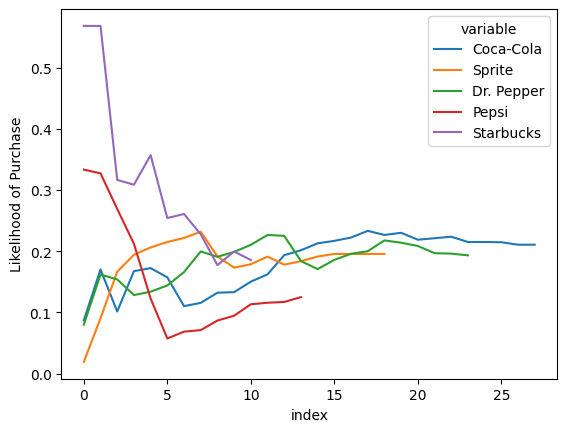

In [35]:
fm_ = visualize(fm)
sns.lineplot(x="index", y="Likelihood of Purchase", data=fm_[fm_["customer_brand"] == "772-4"], hue = "variable")